# Daten einlesen

In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
import pygame

pygame 2.6.1 (SDL 2.28.4, Python 3.11.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [6]:
dat_mat = scipy.io.loadmat("TrafficDataset/sequence_data1-1_2.mat")
dat_mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'sequences'])

## repackage data

In [8]:
data_array = np.array(dat_mat["sequences"])
data = []
for part in data_array:
    data.append(part[0][0][0][0])

In [9]:
data

[array([[24.77925585, 28.12730199, 32.0073716 , 35.92546024, 39.19955003],
        [42.85367035, 47.48185611, 50.58399868, 54.90623485, 57.92641874],
        [60.92779019, 64.6900691 , 67.19027318, 70.24255403, 74.05892331]]),
 array([[51.15375275, 56.90807466, 61.63638957, 66.56278159, 71.83926539],
        [61.50266465, 64.50889574, 67.67516339, 71.81155419, 76.5100543 ],
        [63.44997437, 66.63222914, 71.23864806, 75.95713313, 80.03960365]]),
 array([[35.88146118, 40.94760944, 46.89583652, 51.78206315, 56.32432374],
        [44.48773157, 48.39189475, 51.82406349, 56.55233861, 62.63475117],
        [67.19229719, 71.08265443, 73.80493056, 76.68324537, 79.50157596]]),
 array([[10.67433763, 12.74634334, 14.82035135, 17.89836825, 20.38638611],
        [30.26506941, 34.95116597, 39.52528725, 43.68742498, 48.39361876],
        [61.40465781, 65.09494376, 69.96537373, 75.37592642, 79.3463857 ]]),
 array([[56.57205101, 60.3302939 , 64.39060532],
        [72.61677548, 76.32716579, 80.29762

Nur 3 orts-koordinaten, keine zeit komponente

In [1]:
import h5py# mit h5py
with h5py.File('sequence_data1-1_1.mat', 'r') as f:
    data = f['sequences'][:]

ModuleNotFoundError: No module named 'h5py'

Will nicht funktionieren

In [3]:
from mat4py import loadmat

data = loadmat('sequence_data1-1_1.mat')
data["sequences"][2]

[{'Xarr': [[2.7333870214228604,
    7.903389478164454,
    13.903402095880141,
    18.65342470966774,
    24.63347589178313,
    29.643543786864086],
   [24.601255140716756,
    30.821354526237435,
    37.585509490772104,
    42.823671644279,
    48.24589489492888,
    53.878179294034865],
   [57.93441824708709,
    64.33488214219652,
    68.2252128980101,
    75.3759264227799,
    80.62158589363108,
    85.86724536448186]],
  'Tarr': [72.44, 72.64, 72.84, 73.04, 73.24000000000001, 73.44]}]

Dies kann durchaus richtig sein... \
Tarr - Zeit-Komponente\
Xarr - Orts-Komonente 


In [4]:
# Kosten funktional
def J (x, tau, x_data):
    result = 0
    for i in range(len(x)):
        result += tau * np.abs(x[i] - x_data[i])**2
    return result

In [5]:
# Den mittlwert von J jederzeit ausgeben können:
class J_mittel():
    __val = 0
    __n = 0
    def set_val(self, x):
        self.__val = x
        return
    def set_n(self, x):
        self.__n = x
        return
    
    def get_val(self):
        return self.__val
    def get_n(self):
        return self.__n
    
    def get_res(self):
        return self.__val/self.__n

    def __init__(self, x):
        self.__val = x
        self.__n = 1
        return
    
    def add(self, x):
        self.__val += x
        self.__n += 1
        return

J = J_mittel(0)
for i in range(1, 11):
    J.add(i)

J.get_res()

5.0

In [ ]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
import pygame

# Kosten funktional
def J (x, dt, x_data):
    result = 0
    for i in range(len(x)):
        result += dt * np.abs(x[i] - x_data[i])**2
    return result

def f (d, v_max, model = "log"):
    if model == "log":
        return v_max * np.log(d)
    else: # lin
        return v_max * (1 - 1/d)
    
# Den mittlwert von J jederzeit ausgeben können:
class J_mittel():
    __val = 0
    __n = 0
    def set_val(self, x):
        self.__val = x
        return
    def set_n(self, x):
        self.__n = x
        return
    
    def get_val(self):
        return self.__val
    def get_n(self):
        return self.__n
    
    def get_res(self):
        return self.__val/self.__n

    def __init__(self, x):
        self.__val = x
        self.__n = 1
        return
    
    def add(self, x):
        self.__val += x
        self.__n += 1
        return

def d(x, max_W = 2000, loop = True): # Abstandsfunktion, damit immer des nächste auto VOR dem derzeitig betrachteten auto berücksichtigt wird
    d = np.ones_like(x) * 10**10 # anfangs distanz auf sehr groß setzen
    for i in range(len(x)):
        for j in range(len(x)):
            if i == j:
                continue
            else:
                d[i] = x[j]-x[i] if d[i] > x[j]-x[i] and x[j]-x[i] > 0 else d[i]
            if loop and i == len(x)-1: # abnhängig von der breite der anzeige wird nun der abstand zu den anderen autos überprüft
                d[i] = x[j]-((x[i]-max_W)) if d[i] > x[j]-(x[i]-max_W) and x[j]-(x[i]-max_W) > 0 else d[i]
    return d

def single_step(x, v_max, L, dt, model, max_W):
    N = len(x) # Number of initial values == number of vehicles in traffic
    dx = np.zeros(N) # momente initialisieren
    # Leader
    # dx[-1] = v_max
    dist = d(x, max_W)
    for i in range(N):
            
            dx[i] = f(dist[i], v_max, model)
        
    return x + dt * dx, dx

def simulation_screen(x0, v_max, L, dt, model):
    pygame.init()
    W, H = 1500, 200
    screen = pygame.display.set_mode((W, H))
    clock = pygame.time.Clock()
    scale = 10     # skaliert Meter → Pixel
    running = True
    x = np.array(x0, dtype=float)
    while running:
        clock.tick(60) # 60 FPS
        
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False             # Stop when closed
        
        x, v = single_step(x, v_max, L, dt, model, max_W = W)

        screen.fill((30, 30, 30))

        for i in range(len(x)):
            px = int(x[i]*scale)% W # start again from the beginning of the screen if done with the lap
            py = H // 2 # bewegt sich auf der hälfter der screen höhe
            if i == len(x)-1:
                pygame.draw.circle(screen, (255, 200, 100), (px, py), 8) #cars
            else:
                pygame.draw.circle(screen, (100, 200, 255), (px, py), 8) #cars

            #vx = int(v[i] *0.4) # 0.4 skarilerungs faktor für weniger clutter
            #pygame.draw.line(screen, (255, 160, 60), (py, py), (px+vx, py), 3)  #geschwindigkeits indikator linie
            # Geschwindigkeitspfeil
            vx = int(v[i] * 2)     # skaliert für Anzeige
            pygame.draw.line(screen, (255, 160, 60), (px, py), (px + vx, py), 3)

        pygame.display.flip() # display and render 
    pygame.quit()

pygame 2.6.1 (SDL 2.28.4, Python 3.12.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


/home/tim/miniconda3/envs/Opt1/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [ ]:
# Parameter
N = 4 # Anzahl autos
FPS = 60
scale_m_zu_px = 10
v_kmh = 100
v_max = v_kmh * scale_m_zu_px / FPS * 1000/3600 # km/h -> m/s
Sicherheitsabstand_m = 50 
L =  Sicherheitsabstand_m * scale_m_zu_px
x0 = np.arange(100, 100+40*N, step=40)      # Startpositionen

print((v_max, L, x0))
simulation_screen(x0, v_max, L, dt=1/FPS, model="log")


In [10]:
from mat4py import loadmat
import numpy as np

data = loadmat('sequence_data1-1_1.mat')["sequences"][:]
len(data)

28

In [10]:
test = data[0]
test[0].get("Xarr"), test[0].get("Tarr"), [i[0] for i in test[0].get("Xarr")]

([[47.39131045666992, 53.82017733698899, 60.3346047963812],
  [51.39004618507265, 55.5442699154838, 60.39859453202452],
  [71.53057023567337, 77.25613793806153, 82.38676944064528]],
 [14.240000000000002, 14.440000000000001, 14.64],
 [47.39131045666992, 51.39004618507265, 71.53057023567337])

In [13]:
np.array(test[0].get("Tarr")).shape

(3,)

In [55]:
from mat4py import loadmat
import numpy as np



class data_class():
	__data = []
	__len = 0
	__x = np.ndarray
	__t = np.ndarray
	__counter = 0

	def get_x(self):
		return self.__x
	def get_t(self):
		return self.__t
	def set_x(self, x):
		self.__x = x
		return 
	def set_t(self, x):
		self.__t = x
		return
	def set_counter(self, x):
		self.__counter = x
		return
	def __init__(self, path):
		self.__data = loadmat(path)["sequences"][:]
		self.__len = len(self.__data)
		self.__counter = 0
		self.setXYTFromData(self.__counter)
		return
	def setXYTFromData(self, x):
		self.__x = np.array(self.__data[x][0].get("Xarr"))
		self.__t = np.array(self.__data[x][0].get("Tarr"))
		return 
	def next_dataset(self):
		if self.__counter < self.__len - 1:
			self.__counter += 1
			self.setXYTFromData(self.__counter)
			return
		else:
			self.__counter += 1
			print(f"Error: Index {self.__counter} is out of range of the dataset with length {self.__len} !!!")
			return
	def getCurrentCoords(self, i):
		maxZeilen = self.__x.shape[0]
		maxSpalten = self.__x.shape[1]
		xVals = np.array([self.__x[j, i] for j in range(maxZeilen) if i < maxSpalten])
		tVal = self.__t[i] if i < maxSpalten else None
		return xVals, tVal


In [35]:
test = data_class("TrafficDataset\sequence_data1-1_1.mat")
for i in range(30):
    test.next_dataset()

Error: Index 28 is out of range of the dataset with length 28 !!!
Error: Index 29 is out of range of the dataset with length 28 !!!
Error: Index 30 is out of range of the dataset with length 28 !!!


<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\tlock\AppData\Local\Temp\ipykernel_10404\137318187.py:1: SyntaxWarning: invalid escape sequence '\s'
  test = data_class("TrafficDataset\sequence_data1-1_1.mat")


In [51]:
test.get_x().shape, test.get_x(), test.get_t()

((3, 4),
 array([[42.76867897, 46.7838224 , 49.47395045, 52.1640785 ],
        [56.8565305 , 59.60570332, 61.99086738, 64.1910352 ],
        [80.39402663, 82.26177037, 84.12951412, 85.99725787]]),
 array([573.84, 574.04, 574.24, 574.44]))

In [56]:
def getCurrentCoords(data:data_class, i):
    maxZeilen = data.get_x().shape[0]
    maxSpalten = data.get_x().shape[1]
    xVals = np.array([data.get_x()[j, i] for j in range(maxZeilen) if i < maxSpalten])
    tVal = data.get_t()[i] if i < maxSpalten else None
    return xVals, tVal
getCurrentCoords(test, 3)

(array([52.1640785 , 64.1910352 , 85.99725787]), np.float64(574.4399999999999))

Funktioniert wie gewollt

In [59]:
from mat4py import loadmat
import numpy as np



class data_class():
	__data = []
	__len = 0
	__x = np.ndarray
	__t = np.ndarray
	__counter = 0
	__unterCounter = 0

	def get_x(self):
		return self.__x
	def get_t(self):
		return self.__t
	def set_x(self, x):
		self.__x = x
		return 
	def set_t(self, x):
		self.__t = x
		return
	def set_counter(self, x):
		self.__counter = x
		return
	def __init__(self, path):
		self.__data = loadmat(path)["sequences"][:]
		self.__len = len(self.__data)
		self.__counter = 0
		self.setXYTFromData(self.__counter)
		return
	def setXYTFromData(self, x):
		self.__x = np.array(self.__data[x][0].get("Xarr"))
		self.__t = np.array(self.__data[x][0].get("Tarr"))
		return 
	def next_dataset(self):
		if self.__counter < self.__len - 1:
			self.__counter += 1
			self.setXYTFromData(self.__counter)
			return
		else:
			self.__counter += 1
			print(f"Error: Index {self.__counter} is out of range of the dataset with length {self.__len} !!!")
			return
	def getCurrentCoords(self, i=None):
		if i == None:
			i = self.__unterCounter
		maxZeilen = self.__x.shape[0]
		maxSpalten = self.__x.shape[1]
		xVals = np.array([self.__x[j, i] for j in range(maxZeilen) if i < maxSpalten])
		tVal = self.__t[i] if i < maxSpalten else None

		if i == self.__unterCounter:
			self.__unterCounter += 1
		return xVals, tVal


In [83]:
test = data_class("TrafficDataset\sequence_data1-1_1.mat")

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\tlock\AppData\Local\Temp\ipykernel_10404\4089489413.py:1: SyntaxWarning: invalid escape sequence '\s'
  test = data_class("TrafficDataset\sequence_data1-1_1.mat")


In [80]:
test.getCurrentCoords(), test.getCurrentCoords(2)

((array([47.39131046, 51.39004619, 71.53057024]),
  np.float64(14.240000000000002)),
 (array([60.3346048 , 60.39859453, 82.38676944]), np.float64(14.64)))

# Abstandsfunktion

In [81]:
# Test umsortieren und wieder rückgängig machen

test = np.random.randint(0, 10,(10, 3))
order = np.argsort(test[:, 0])
new_x = test[order]
reodererd = new_x[np.argsort(order)]
test, new_x, reodererd == test

(array([[3, 2, 6],
        [5, 4, 7],
        [8, 1, 4],
        [8, 2, 1],
        [5, 0, 2],
        [5, 2, 6],
        [9, 9, 2],
        [0, 7, 1],
        [7, 1, 2],
        [1, 8, 3]], dtype=int32),
 array([[0, 7, 1],
        [1, 8, 3],
        [3, 2, 6],
        [5, 0, 2],
        [5, 2, 6],
        [5, 4, 7],
        [7, 1, 2],
        [8, 1, 4],
        [8, 2, 1],
        [9, 9, 2]], dtype=int32),
 array([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]))

In [95]:
# Neue Abstandsfunktion
def d(x:np.ndarray): # Abstandsfunktion
	d = np.ones_like(x) * np.inf # anfangs distanz auf sehr groß setzen
	order_mask = np.argsort(x) # nach i-ter achse sortieren, hier x achse -> 0
	x_ordered = x[order_mask]
	for i, x_i in enumerate(x_ordered):
		for j, x_j in enumerate(x_ordered[i+1:]): # nur Werte mit größerem Index (i+1) sind für den vergleich relevant, da nur diese vor dem Auto sind.
			dist = np.linalg.norm(x_j - x_i)
			d[i] = dist if d[i] > dist else d[i]
	return d
x, t = test.getCurrentCoords(0)
x, d(x)

(array([47.39131046, 51.39004619, 71.53057024]),
 array([ 3.99873573, 20.14052405,         inf]))

In [108]:
d = 10
v_max = 30
np.min([v_max * np.log(d), v_max]) # Limit für f im "log" model

np.float64(30.0)

In [1]:
from mat4py import loadmat
import numpy as np

# Kosten funktional
def J (x, dt, x_data):
    result = 0
    for i in range(len(x)):
        dt * np.abs(x[i] - x_data[i])**2
    return result

def f (d, v_max, model = "log"):
    if model == "log":
        return np.min([v_max * np.log(d), v_max]) # Limit v_max, wie im linearen modell
    else: # lin
        return v_max * (1 - 1/d)
    
# Den mittlwert von J jederzeit ausgeben können:
class J_mittel():
    __val = 0
    __n = 0
    def set_val(self, x):
        self.__val = x
        return
    def set_n(self, x):
        self.__n = x
        return
    
    def get_val(self):
        return self.__val
    def get_n(self):
        return self.__n
    
    def get_res(self):
        return self.__val/self.__n

    def __init__(self, x):
        self.__val = x
        self.__n = 1
        return
    
    def add(self, x):
        self.__val += x
        self.__n += 1
        return
    

class data_class():
	__data = []
	__len = 0
	__x = np.ndarray
	__t = np.ndarray
	__counter = 0
	__unterCounter = 0

	def get_x(self):
		return self.__x
	def get_t(self):
		return self.__t
	def set_x(self, x):
		self.__x = x
		return 
	def set_t(self, x):
		self.__t = x
		return
	def set_counter(self, x):
		self.__counter = x
		return
	def __init__(self, path):
		self.__data = loadmat(path)["sequences"][:]
		self.__len = len(self.__data)
		self.__counter = 0
		self.setXYTFromData(self.__counter)
		return
	def setXYTFromData(self, x):
		self.__x = np.array(self.__data[x][0].get("Xarr"))
		self.__t = np.array(self.__data[x][0].get("Tarr"))
		return 
	def next_dataset(self):
		if self.__counter < self.__len - 1:
			self.__counter += 1
			self.setXYTFromData(self.__counter)
			return
		else:
			self.__counter += 1
			print(f"Error: Index {self.__counter} is out of range of the dataset with length {self.__len} !!!")
			return
	def getCurrentCoords(self, i=None):
		if i == None:
			i = self.__unterCounter
		maxZeilen = self.__x.shape[0]
		maxSpalten = self.__x.shape[1]
		xVals = np.array([self.__x[j, i] for j in range(maxZeilen) if i < maxSpalten])
		tVal = self.__t[i] if i < maxSpalten else None

		if i == self.__unterCounter:
			self.__unterCounter += 1
		return xVals, tVal

    
def d(x:np.ndarray): # Abstandsfunktion
	d = np.ones_like(x) * np.inf # anfangs distanz auf sehr groß setzen
	order_mask = np.argsort(x) # nach i-ter achse sortieren, hier x achse -> 0
	x_ordered = x[order_mask]
	for i, x_i in enumerate(x_ordered):
		for j, x_j in enumerate(x_ordered[i+1:]): # nur Werte mit größerem Index (i+1) sind für den vergleich relevant, da nur diese vor dem Auto sind.
			dist = np.linalg.norm(x_j - x_i)
			d[i] = dist if d[i] > dist else d[i]
	return d

In [2]:
test = data_class("TrafficDataset/sequence_data1-1_1.mat")
x, t = test.getCurrentCoords()
dist =  d(x)
x, t, dist

(array([47.39131046, 51.39004619, 71.53057024]),
 np.float64(14.240000000000002),
 array([ 3.99873573, 20.14052405,         inf]))

# Interpolationsfunktion

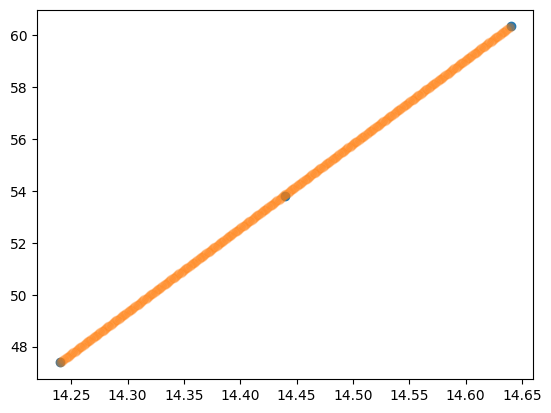

In [ ]:
ort = test.get_x()[0,:]
zeit = test.get_t()
dt = 0.001
steigung = (np.max(ort)-np.min(ort))/(np.max(zeit)-np.min(zeit))
ort_int = steigung * np.arange(0, np.max(zeit)-np.min(zeit), dt) + np.min(ort)
zeit_int = np.arange(zeit[0], zeit[-1], dt)

from matplotlib import pyplot as plt
plt.plot(zeit, ort, "o")
plt.plot(zeit_int, ort_int, "o", alpha = 0.2)
plt.show()

In [10]:
test = data_class("TrafficDataset/sequence_data1-1_1.mat")
test.next_dataset()
ort, zeit = test.get_x(), test.get_t()
ort, zeit, ort.shape, len(zeit)

(array([[39.20354853, 44.53373068, 50.34401771, 56.15430475, 61.56970303,
         66.98510131],
        [46.59381456, 51.92406617, 57.81944964, 63.71483312, 68.67528654,
         73.63573996],
        [67.1031215 , 73.22570523, 79.22237926, 86.72138461, 92.25823097,
         97.64116926]]),
 array([23.64, 23.84, 24.04, 24.24, 24.44, 24.64]),
 (3, 6),
 6)

In [ ]:
from opt_lib import *
def LinInterplation(data, dt=0.001):
	ort = data.get_x()
	zeit = data.get_t()
	zeit_int = np.arange(zeit[0], zeit[-1], dt)
	ort_int = np.zeros((ort.shape[0], len(zeit_int)))
	for i, auto in enumerate(ort):
		steigung = (np.max(auto)-np.min(auto))/(np.max(zeit)-np.min(zeit))
		ort_int[i,:] = steigung * np.arange(0, np.max(zeit)-np.min(zeit), dt) + np.min(auto)
	return ort_int, zeit_int


dt = 0.0001
test = data_class("TrafficDataset/sequence_data1-1_1.mat")
test.next_dataset()
ort, zeit = test.get_x(), test.get_t()
ort_int, zeit_int = LinInterplation(test, dt)
ort, ort_int.shape

(array([[39.20354853, 44.53373068, 50.34401771, 56.15430475, 61.56970303,
         66.98510131],
        [46.59381456, 51.92406617, 57.81944964, 63.71483312, 68.67528654,
         73.63573996],
        [67.1031215 , 73.22570523, 79.22237926, 86.72138461, 92.25823097,
         97.64116926]]),
 (3, 1000))

In [2]:
indes = np.where((zeit_int >= (zeit[1] - dt/2)) & (zeit_int <= (zeit[1] + dt/2)))
len(indes), indes

(2, (array([], dtype=int64), array([], dtype=int64)))

In [46]:
zeit[1], zeit_int[indes]

(np.float64(14.440000000000001), array([14.44]))

In [19]:
# testgröße wie gut die interpolation war
def test_interpolation(data, ort_int, zeit_int, dt):
	ort, zeit = data.get_x(), data.get_t()
	rel_fehler = np.zeros(ort.shape[0])
	for i, auto in enumerate(ort):
		for x, t in zip(auto, zeit):
			index = np.where((zeit_int >= (t - dt/2)) & (zeit_int <= (t + dt/2)))[0]
			if len(index) != 0:
				abs_fehler = np.abs(x-ort_int[i, index])
				rel_fehler[i] = rel_fehler[i] + abs_fehler/np.abs(x)
	avg_fehler = rel_fehler/len(zeit)
	if np.sum(avg_fehler >= 0.05) > 1:
		print("ACHTUNG mindestenz einmal eine größere Abweichung als 5%")
	return avg_fehler

test_interpolation(test, ort_int, zeit_int, dt)

C:\Users\tlock\AppData\Local\Temp\ipykernel_13572\60614885.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rel_fehler[i] = rel_fehler[i] + abs_fehler/np.abs(x)


array([0.00215638, 0.00485986, 0.00403475])

# Neuer Ablauf:

In [1]:
from opt_lib import *
dt = 0.001
test = data_class("TrafficDataset/sequence_data1-1_1.mat")
test.next_dataset()
ort, zeit = test.get_x(), test.get_t()
ort_int, zeit_int = test.LinInterplation(dt)
ort, ort_int.shape

(array([[39.20354853, 44.53373068, 50.34401771, 56.15430475, 61.56970303,
         66.98510131],
        [46.59381456, 51.92406617, 57.81944964, 63.71483312, 68.67528654,
         73.63573996],
        [67.1031215 , 73.22570523, 79.22237926, 86.72138461, 92.25823097,
         97.64116926]]),
 (3, 1000))

In [147]:
from opt_lib import *

dt = 0.001
test = data_class("TrafficDataset/sequence_data1-1_1.mat")
test.next_dataset() # Nächster Datensatz
test.LinInterplation(dt) # mit dt schrittweite, denn Datensatz interpolieren
print(test.test_interpolation(dt)) # durchschnittlicher Fehler der Interpolation abfragen
test.switch_iteration() # Die interpolierten werte als zu berücksichtigende Daten setzen
test.getCurrentCoords(0) # Aktuelle ort, zeit punkte der autos ausgeben

[0.00215638 0.00485986 0.00403475]


(array([39.20354853, 46.59381456, 67.1031215 ]), np.float64(23.64))

In [221]:
def f (d, v_max, model = "log"):
    if model == "log":
        return np.min([v_max * np.log(d), v_max], 1) # Limit v_max, wie im linearen modell
    else: # lin
        return v_max * (1 - 1/d)

def single_step(x, v_max, L, dt, model):
    N = len(x) # Number of initial values == number of vehicles in traffic
    dx = np.zeros(N) # momente initialisieren
    # Leader
    # dx[-1] = v_max
    dist = d(x)/L
    # for i in range(N):
    #         dx[i] = f(dist[i], v_max, model)
    dx = f(dist, v_max, model)
    return x + dt * dx, dx

L = 3
v_max = 40

x, t = test.getCurrentCoords(0)
newX, _ = single_step(x, v_max, L, dt, "lin")
newX

array([39.22731096, 46.62796355, 67.1431215 ])

In [224]:
def J (x, dt, x_data):
    result = 0
    for i in range(len(x)):
        result += dt * np.abs(x[i] - x_data[i])**2
    return result

x_soll, _ = test.getCurrentCoords(1)
Sammel_J = J_mittel(J(newX, dt, x_soll))

Sammel_J.get_val()

np.float64(1.561924075228209e-07)

# Nun alles zusammen

In [1]:
from opt_lib import *
# Parameter definieren
dt = 0.001
L = 3
v_max = 20

test = data_class("TrafficDataset/sequence_data1-1_1.mat")
test.next_dataset() # Nächster Datensatz
test.LinInterplation(dt) # mit dt schrittweite, denn Datensatz interpolieren
print(test.test_interpolation(dt)) # durchschnittlicher Fehler der Interpolation abfragen
test.switch_iteration() # Die interpolierten werte als zu berücksichtigende Daten setzen

x_num = np.zeros_like(test.get_x())# Array definieren, in dem die numerisch bestimmten ort abgespeichert werden
J_array = np.zeros(test.get_t().shape[0] - 1) # Array definieren, in dem der Loss abgespeichert wird

for i in range(len(J_array)+1):
	x_soll, t_soll = test.getCurrentCoords() # Aktuelle ort, zeit punkte der autos ausgeben
	if i != 0: # Falls wir schon einen Schritt gegangen sind
		J_array[i-1] = J(x, dt, x_soll) # Loss berechnen
	else: # Falls der erste durchlauf
		x, t = x_soll, t_soll
	dist = d(x) # Distanzen zwischen den autos berechnen
	x, _ = single_step(x, v_max, L, dt, "lin") # x aktualisieren
	x_num[:,i] = x
	t += dt

test.getCurrentCoords() # Test, ob alle Daten abgegangen wurden

[0.00215638 0.00485986 0.00403475]


(array([], dtype=float64), None)

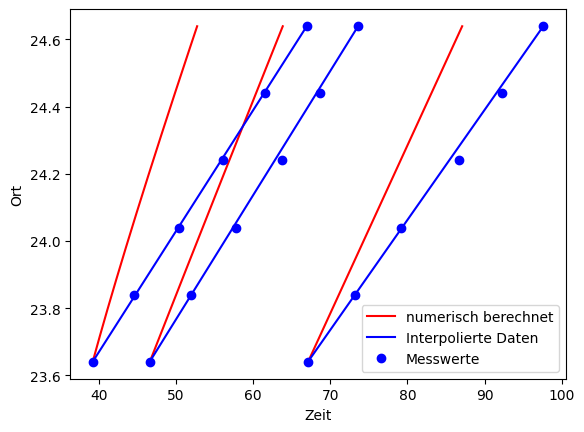

Der Fehler der Interpolation ist je
Auto	|	Realtiver Fehler
-------------------------------
0	|	0.21563765010056296
1	|	0.4859857409523441
2	|	0.4034747991826581


In [ ]:
# Visualisieren
from matplotlib import pyplot as plt

plt.plot(x_num[0,:], test.get_t(), color = "red")
plt.plot(x_num[1,:], test.get_t(), color = "red")
plt.plot(x_num[2,:], test.get_t(), color = "red", label = "numerisch berechnet")
plt.plot(test.get_x()[0,:], test.get_t(), color = "blue")
plt.plot(test.get_x()[1,:], test.get_t(), color = "blue")
plt.plot(test.get_x()[2,:], test.get_t(), color = "blue", label = "Interpolierte Daten")
plt.plot(test.get_xIt()[0,:], test.get_tIt(), "o", color = "blue")
plt.plot(test.get_xIt()[1,:], test.get_tIt(), "o", color = "blue")
plt.plot(test.get_xIt()[2,:], test.get_tIt(), "o", color = "blue", label = "Messwerte")
plt.legend()
plt.xlabel("Zeit")
plt.ylabel("Ort")
plt.show()
print(f"Der Fehler der Interpolation ist je")
print("Auto\t|\tRealtiver Fehler")
print("-------------------------------")
for i, err in enumerate(test.get_ItError()):
    print(f"{i}\t|\t{err*100}")

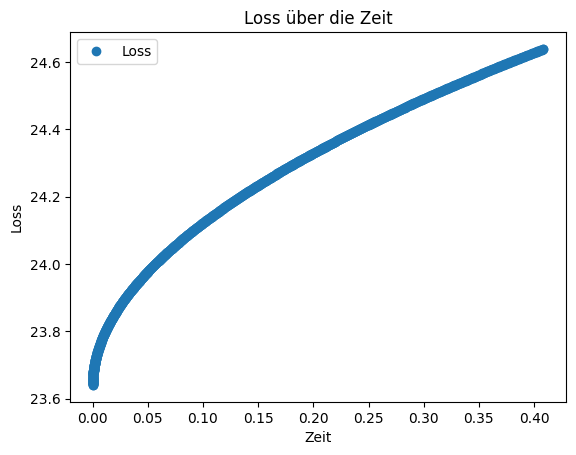

der durchschnittliche Loss ist: 0.1395953921673347


In [30]:
plt.plot(J_array, test.get_t()[1:], "o", label = "Loss")
plt.xlabel("Zeit")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss über die Zeit")
plt.show()
print(f"der durchschnittliche Loss ist: {np.sum(np.abs(J_array))/len(J_array)}")